In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import torch
import numpy as np

G_MODEL_STATE_KEY = 'g_model_state'
D_MODEL_STATE_KEY = 'd_model_state'
G_OPTIMIZER_STATE_KEY = 'g_optimizer_state'
D_OPTIMIZER_STATE_KEY = 'd_optimizer_state'

def save_loss_csv(path, g_losses, d_losses):
    np.savetxt(path, (g_losses, d_losses), delimiter=',', header=','.join(['g_loss', 'd_loss']), comments='')

def save_checkpoint(path, g_model, g_optimizer, d_model, d_optimizer):
    checkpoint_data = {
        G_MODEL_STATE_KEY: g_model.state_dict(),
        G_OPTIMIZER_STATE_KEY: g_optimizer.state_dict(),
        D_MODEL_STATE_KEY: d_model.state_dict(),
        D_OPTIMIZER_STATE_KEY: d_optimizer.state_dict(),
    }

    torch.save(checkpoint_data, path)

class CheckpointLoader:
    def __init__(self, path):
        self.checkpoint = torch.load(path, weights_only=True)

    def load_models(self, g_model, d_model):
        g_model.load_state_dict(self.checkpoint[G_MODEL_STATE_KEY])
        d_model.load_state_dict(self.checkpoint[D_MODEL_STATE_KEY])

    def load_optimizers(self, g_optimizer, d_optimizer):
        g_optimizer.load_state_dict(self.checkpoint[G_OPTIMIZER_STATE_KEY])
        d_optimizer.load_state_dict(self.checkpoint[D_OPTIMIZER_STATE_KEY])

In [ ]:
import argparse
import os
import numpy as np
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.autograd as autograd
import torch

from pathlib import Path

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)
#torch.use_deterministic_algorithms(True)

save_path = Path('/content/drive/MyDrive/DataScience/HW4_ver8')
checkpoints_path = save_path / "checkpoints"
images_path = save_path / "images"
losses_path = save_path / 'losses.csv'

checkpoints_path.mkdir(parents=True, exist_ok=True)
images_path.mkdir(parents=True, exist_ok=True)

cli = False

if cli:
    parser = argparse.ArgumentParser()
    parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
    parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
    parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
    parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
    parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
    parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
    parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
    parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
    parser.add_argument("--channels", type=int, default=1, help="number of image channels")
    parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
    parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
    parser.add_argument("--checkpoint_interval", type=int, default=10, help="interval between model checkpoints")
    opt = parser.parse_args()
    print(opt)
else:
    opt = argparse.Namespace()
    opt.epoch = 0
    opt.n_epochs = 1000
    opt.batch_size = 64
    opt.lr = 0.0002
    opt.b1 = 0.5
    opt.b2 = 0.999
    opt.latent_dim = 100
    opt.img_size = 28
    opt.channels = 1
    opt.n_critic = 5
    opt.sample_interval = 50
    opt.checkpoint_interval = 5
    print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if opt.epoch != 0:
    # Load pretrained models
    checkpoint_loader = CheckpointLoader(checkpoints_path / f"checkpoint_{opt.epoch}.tar")
    checkpoint_loader.load_models(generator, discriminator)
else:
    checkpoint_loader = None

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("./data", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# ----------
#  Training
# ----------

batches_done = 0
g_losses = []
d_losses = []

for epoch in range(opt.epoch, opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            if i % opt.sample_interval == 0:#batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], images_path / f"{epoch}_{batches_done}.png", nrow=5, normalize=True)

            batches_done += opt.n_critic

    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, opt.n_epochs, d_loss.item(), g_loss.item())
    )

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    save_loss_csv(losses_path, g_losses, d_losses)

    if epoch % opt.checkpoint_interval == 0:
        save_checkpoint(checkpoints_path / f"checkpoint_{epoch}.tar", generator, optimizer_G, discriminator, optimizer_D)

Namespace(epoch=50, n_epochs=1000, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, n_critic=5, clip_value=0.01, sample_interval=50, checkpoint_interval=5)
[Epoch 50/1000] [D loss: -1.601231] [G loss: -2.936568]
[Epoch 51/1000] [D loss: -1.736537] [G loss: -2.772551]
[Epoch 52/1000] [D loss: -1.161061] [G loss: -1.956176]
[Epoch 53/1000] [D loss: -2.058687] [G loss: -2.580967]
[Epoch 54/1000] [D loss: -2.211116] [G loss: -2.566844]
[Epoch 55/1000] [D loss: -1.642945] [G loss: -3.015171]
[Epoch 56/1000] [D loss: -1.329248] [G loss: -3.246290]
[Epoch 57/1000] [D loss: -0.895157] [G loss: -2.878674]
[Epoch 58/1000] [D loss: -1.701469] [G loss: -2.417342]
[Epoch 59/1000] [D loss: -1.524461] [G loss: -2.371675]
[Epoch 60/1000] [D loss: -1.049005] [G loss: -2.252615]
[Epoch 61/1000] [D loss: -1.269904] [G loss: -2.304842]
[Epoch 62/1000] [D loss: -0.931852] [G loss: -2.398452]
[Epoch 63/1000] [D loss: -1.046606] [G loss: -1.347685]
[Epoch 64/1000]

In [10]:
import numpy as np
import math

def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

data = np.loadtxt('losses.csv', delimiter=',')
g_losses = data[0]
d_losses = data[1]

weight = 0.8
g_losses_smooth = smooth(g_losses, weight)
d_losses_smooth = smooth(d_losses, weight)

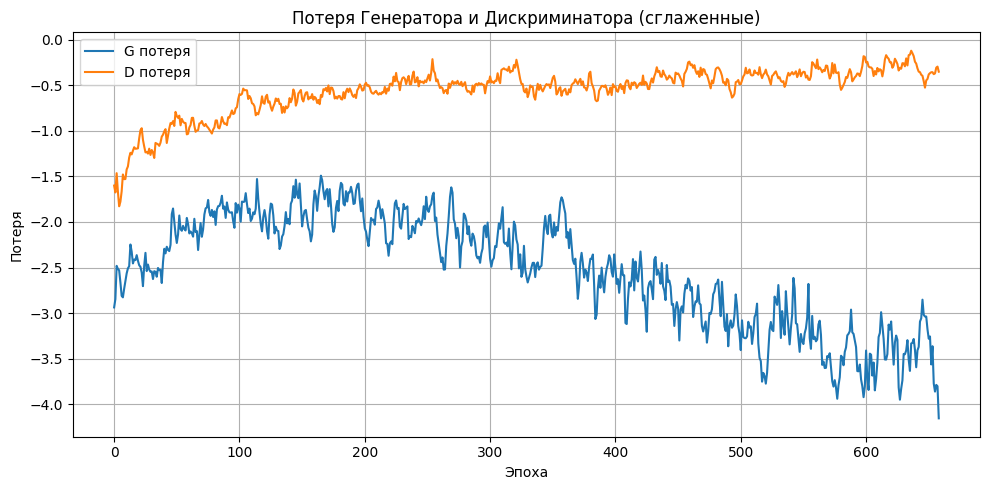

In [24]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 5))
#plt.title("Потеря Генератора и Дискриминатора")
#plt.plot(g_losses, label="G потеря")
#plt.plot(d_losses, label="D потеря")
#plt.xlabel("Эпоха")
#plt.ylabel("Потеря")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(10, 5))
plt.title("Потеря Генератора и Дискриминатора (сглаженные)")
plt.plot(g_losses_smooth, label="G потеря")
plt.plot(d_losses_smooth, label="D потеря")
plt.xlabel("Эпоха")
plt.ylabel("Потеря")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Использовался *Wasserstein GAN* c *Gradient Penalty*.

Сеть обучается на наборе данных *MNIST*.

Динамика обучения модели *WGAN-GP* выглядит стабильной, на что указывает потеря дискриминатора, сохраняющая отрицательные значения с умеренными колебаниями, и потеря генератора, демонстрирующая постепенную сходимость. Эти тенденции говорят о том, что генератор обучается эффективно, в то время как дискриминатор сохраняет свою способность отличать реальные образцы от поддельных, что отражает здоровое состязательное обучение.

Обучение модели шло до 709 эпохи, остановилось по причине отвала Гугл Колаб'а.

**Результат:**

![result](result.gif)